# Variational Autoencoders (VAEs)

A VAE is a generative model. Given some samples $x$ drawn from a distribution $D$ (our data), we want to approximate the true distribution $p^*(x)$ with a parametrized distribution $p_\theta(x)$:

given $x \sim D$, we want to optimize for $\theta$ so that 

\begin{equation*}
    p_\theta(x) \approx p^*(x)
\end{equation*}

$p_\theta(x)$ is called the *likelihood*, thus we are in presence of a *Maximum Likelihood Estimation* (MLE) problem.

We assume that each sample of our dataset can be described by a finite set of characteristics called the *latent variables*, that we call $z$. These characteristics are called latent as they are underlying: they capture the variations in our data samples but are not directly observed. To build a better intuition on what latent variables are, consider the following example drawn from [[2]](#sources):

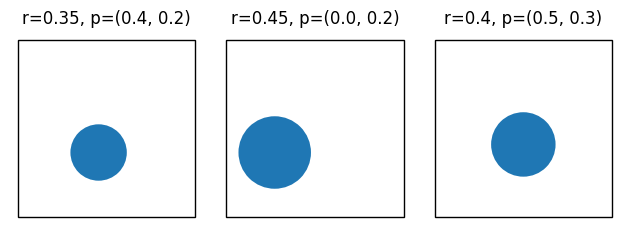

In [8]:
from random import randint

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

num_examples = 3

fig, axs = plt.subplots(1, num_examples)

for ax_index in range(num_examples):
    radius = randint(1, 10) / 20
    position = (randint(0, 10) / 10, randint(0, 10) / 10)

    ax = axs[ax_index]
    ax.set_aspect("equal", "box")
    ax.add_artist(mpatches.Circle(position, radius))
    ax.add_artist(mpatches.Rectangle((-0.6, -0.6), width=2.2, height=2.2, fill=False))

    ax.set_xlim((-0.7, 1.7))
    ax.set_ylim((-0.7, 1.7))
    ax.set_axis_off()

    ax.set_title(f"r={radius}, p={position}")

fig.tight_layout()

In the example above, our dataset is composed of images of blue circles ; the underlying characteristics of any given circle are its radius and its position. Those two latent variables are not directly observed on our images, although they can be inferred. On a more complex case like handwritten digits, latent variables could be the size of the stroke, the position, the stroke style, ...

It now appears that each and every sample can be described in the *data space* or the *latent space*. A VAE is able to perform both inference and generation:

* **inference**: infer the latent variables $z$ from the data point $x$ i.e computing $p_\theta(z|x)$
* **generation**: generate a data point $x$ from a the latent variables $z$ i.e computing $p_\theta(x|z)$

Remembering we want to adjust our set of parameters $\theta$ such that we maximise our likelihood $p_\theta(x)$ for any data point $x$, we can write the marginal likelihood as:

\begin{equation*}
    \begin{aligned}
        p_\theta(x) & = \int_z p_\theta(x, z) dz \\
        & = \int_z p_\theta(z) p_\theta(x|z) dz
    \end{aligned}
\end{equation*}

It turns out this integral is intractable: there are no analytical solutions and its numerical computation require an amount of samples that grow exponentially with the number of latent variables.

<span id="eq1"></span>

However, Bayes can bail us out of this seemingly impossible situation:

\begin{align*}
    p_\theta(x) & = \frac{p_\theta(x, z)}{p_\theta(z|x)} \\
    & = \frac{p_\theta(z) p_\theta(x|z)}{p_\theta(z|x)}
\end{align*}

where:

* $p_\theta(x|z)$ is the likelihood
* $p_\theta(x)$ is the marginal likelihood (marginalized over all possible $z$)
* $p_\theta(z)$ is the *prior* distribution (it can be understood as the probability of our model before having seen any data)
* $p_\theta(z|x)$ is the *posterior* distribution

![VAE schema](VAE.png "VAE schema")

We already concluded that the computation of $p_\theta(x)$ is out of our reach. However, in order to maximize our marginal likelihood, we see from <a href="#eq1">(1)</a> that knowing the posterior distribution could be enough to reach our goal. Since we don't know the analytical form of the posterior, we can approximate it with a known distribution $q_\phi(z|x)$. This is the core principle of variationnal inference [[3]](#sources), optimizing $\phi$ for 

\begin{equation*}
    q_\phi(z|x) \approx p_\theta(z|x)
\end{equation*}

Two things are left for us to do:

1) Choosing the "form" of the distribution (gaussian, Poisson, ...)
2) Optimizing our chosen distribution with respect to its parameters $\phi$

In order to measure how far our approximate distribution lies from the actual posterior distribution, we rely on the Kullback-Leibler divergence [[4]](#sources).

<div class="alert alert-block alert-warning">
    NOTE: KL-divergence is not a distance as it is not symmetrical !
</div>

Unwrapping the raw Kullback-Leibler equation, we can write:

\begin{align*}
    D_{KL}(q_\phi || p_\theta) & = \int_z q_\phi(z|x) \log \left( \frac{q_\phi(z|x)}{p_\theta(z|x)} \right) dz \\
    & = \int_z q_\phi(z|x) \log \left( \frac{q_\phi(z|x) p_\theta(x)}{p_\theta(x, z)} \right) dz \\
    & = \int_z q_\phi(z|x) \log(q_\phi(z|x)) dz + \int_z q_\phi(z|x) \log(p_\theta(x)) dz - \int_z q_\phi(z|x) \log(p_\theta(x, z)) dz \\
    & = \mathbb{E}_{z \sim q_\phi(\cdot|x)} \left[ \log(q_\phi(z|x)) \right] + \log(p_\theta(x)) - \mathbb{E}_{z \sim q_\phi(\cdot|x)} \left[ \log(p_\theta(x, z)) \right] \\
    & = \log(p_\theta(x)) - \mathbb{E}_{z \sim q_\phi(\cdot|x)} \left[ \log(p_\theta(x, z)) - \log(q_\phi(z|x)) \right]
\end{align*}

We derived a new expression for our marginal log-likelihood :

\begin{equation*}
    \log(p_\theta(x)) = \mathbb{E}_{z \sim q_\phi(\cdot|x)} \left[ \log \left( \frac{p_\theta(x, z)}{q_\phi(z|x)} \right) \right] + D_{KL}(q_\phi || p_\theta)
\end{equation*}

Maximizing the log-likelihood is the same as maximizing the expected value of $\log \left( \frac{p_\theta(x, z)}{q_\phi(z|x)} \right)$ because the KL-divergence term is greater than zero ([proof](#appendix-a---proving-the-positivity-of-the-kullback-leibler-divergence)). This term is called the Evidence Lower BOund, or ELBO for short, because:

\begin{equation*}
    \mathbb{E}_{z \sim q_\phi(\cdot|x)} \left[ \log \left( \frac{p_\theta(x, z)}{q_\phi(z|x)} \right) \right] \le \log(p_\theta(x))
\end{equation*}

Finally, writing the equation as:

\begin{equation*}
    \mathbb{E}_{z \sim q_\phi(\cdot|x)} \left[ \log \left( \frac{p_\theta(x, z)}{q_\phi(z|x)} \right) \right] = \log(p_\theta(x)) - D_{KL}(q_\phi || p_\theta)
\end{equation*}

we see hat maximizing the expected value will both maximize the likelihood and minimize the KL divergence. However, we don't know the joint probability distribution of the observed data and the latent variables. We still need to work a bit more :


\begin{align*}
    \mathbb{E}_{z \sim q_\phi(\cdot | x)} \left[ \log \left( \frac{p_\theta(x, z)}{q_\phi(z|x)} \right) \right] & = \mathbb{E}_{z \sim q_\phi(\cdot | x)} \left[ \log \left( \frac{p_\theta(x|z) p_\theta(z)}{q_\phi(z|x)} \right) \right] \tag{Bayes' theorem} \\
    & = \mathbb{E}_{z \sim q_\phi(\cdot | x)} \left[ \log(p_\theta(x|z)) + \log \left( \frac{p_\theta(z)}{q_\phi(z|x)} \right) \right] \\
    & = \mathbb{E}_{z \sim q_\phi(\cdot | x)} \left[ \log(p_\theta(x|z)) \right] + \mathbb{E}_{z \sim q_\phi(\cdot | x)} \left[ \log \left( \frac{p_\theta(z)}{q_\phi(z|x)} \right)\right] \tag{expectation linearity} \\
    & = \log(p_\theta(x|z)) - D_{KL} (q_\phi(z|x) || p_\theta(z)) \\
    & \le \log(p_\theta(x))
\end{align*}

Instead of a maximization problem, we prefer to solve our loss function. Therefore, we define our training loss as such :

\begin{equation*}
    \mathcal{L}_{\theta, \phi}(x) = D_{KL} (q_\phi(z|x) || p_\theta(z)) - \log(p_\theta(x|z))
\end{equation*}

where :

* $- \log(p_\theta(x|z))$ is the reconstruction term; the lower it gets, the closer the decoded output is to the input
* $D_{KL} (q_\phi(z|x) || p_\theta(z))$ is a regularization term on the latent space; it solely depends on our choices of $p_\theta(z)$ and $q_\phi(z|x)$

Speaking of choosing our prior and our posterior distributions, we make the following assumptions :

* $p_\theta(z) \sim \mathcal{N}(0, I_d)$
* $q_\phi(z|x) \sim \mathcal{N}(\vec{\mu_d}(\phi, x), diag(\vec{\sigma_d}(\phi, x)^2))$

where $d$ is the dimension of the latent space.

## Implementing the VAE

In [9]:
from dataclasses import dataclass

from deep_learner import Tensor, exponential, mean, ones, rand_normal, zeros
from deep_learner.nn import Linear, Module, ReLU, Sequential
from deep_learner.functional import mean_squared_error


@dataclass
class VAEEncoderOutput:
    mean: Tensor
    log_variance: Tensor
    latent: Tensor


@dataclass
class VAEOutput:
    encoder: VAEEncoderOutput
    decoder: Tensor


class VAE(Module):
    def __init__(self, input_dimension: int, latent_dimension: int):
        super().__init__()

        self.encoder = Sequential(
            Linear(n_in=input_dimension, n_out=2 * input_dimension),
            ReLU(),
            Linear(n_in=2 * input_dimension, n_out=input_dimension // 2),
            ReLU(),
            Linear(n_in=input_dimension // 2, n_out=input_dimension // 8),
            ReLU(),
            Linear(n_in=input_dimension // 8, n_out=latent_dimension),
            ReLU(),
        )

        self.mean_layer = Linear(n_in=latent_dimension, n_out=latent_dimension)
        self.log_variance_layer = Linear(n_in=latent_dimension, n_out=latent_dimension)

        self.decoder = Sequential(
            Linear(n_in=latent_dimension, n_out=input_dimension // 8),
            ReLU(),
            Linear(n_in=input_dimension // 8, n_out=input_dimension // 2),
            ReLU(),
            Linear(n_in=input_dimension // 2, n_out=2 * input_dimension),
            ReLU(),
            Linear(n_in=2 * input_dimension, n_out=input_dimension),
        )

    def compute_loss(
        self, x: Tensor, y: Tensor, mean_: Tensor, log_variance: Tensor
    ) -> Tensor:
        reconstruction_loss = mean_squared_error(x, y)
        kl_divergence = mean(
            exponential(log_variance) + mean_**2 - log_variance - Tensor(1).to(x.device)
        ) / Tensor(2).to(x.device)

        return kl_divergence + reconstruction_loss

    def encode(self, x: Tensor) -> VAEEncoderOutput:
        pre_z = self.encoder(x)

        mean = self.mean_layer(pre_z)
        log_variance = self.log_variance_layer(pre_z)

        z = self.reparametrization_trick(mean, log_variance)

        return VAEEncoderOutput(mean=mean, log_variance=log_variance, latent=z)

    def forward(self, x: Tensor) -> VAEOutput:
        enc_out = self.encode(x)

        output = self.decoder(enc_out.latent)

        return VAEOutput(encoder=enc_out, decoder=output)

    def reparametrization_trick(self, mean: Tensor, log_variance: Tensor) -> Tensor:
        epsilon = rand_normal(zeros(mean.data.shape), ones(log_variance.data.shape)).to(
            mean.device
        )

        return mean + exponential(0.5 * log_variance) * epsilon


vae_model = VAE(input_dimension=784, latent_dimension=8)
vae_model

VAE(
    encoder: Sequential(
        (0): Linear(n_in=784, n_out=1568),
        (1): ReLU(),
        (2): Linear(n_in=1568, n_out=392),
        (3): ReLU(),
        (4): Linear(n_in=392, n_out=98),
        (5): ReLU(),
        (6): Linear(n_in=98, n_out=8),
        (7): ReLU()
    ),
    mean_layer: Linear(n_in=8, n_out=8),
    log_variance_layer: Linear(n_in=8, n_out=8),
    decoder: Sequential(
        (0): Linear(n_in=8, n_out=98),
        (1): ReLU(),
        (2): Linear(n_in=98, n_out=392),
        (3): ReLU(),
        (4): Linear(n_in=392, n_out=1568),
        (5): ReLU(),
        (6): Linear(n_in=1568, n_out=784)
    )
)

## Training the VAE on MNIST

### Loading the dataset

In [10]:
import numpy as np
from numpy.typing import NDArray

from deep_learner.datasets import mnist


def preprocess(x) -> NDArray:
    return (x - np.mean(x, axis=0)) / (np.std(x, axis=0) + 1e-6)


def load_mnist() -> tuple[NDArray, NDArray]:
    train_X, _, test_X, _ = mnist()
    train_X = preprocess(train_X.reshape(-1, 784))
    test_X = preprocess(test_X.reshape(-1, 784))

    return train_X, test_X

In [ ]:
import time

from deep_learner import Device, Tensor
from deep_learner.utils import batch
from deep_learner.nn.optimizer import SGD


def compute_losses() -> tuple[float, float]:
    train_output = vae_model(Tensor(train_X).to(DEVICE))
    test_output = vae_model(Tensor(test_X).to(DEVICE))

    train_loss = vae_model.compute_loss(
        x=train_output.decoder,
        y=Tensor(train_X).to(DEVICE),
        mean_=train_output.encoder.mean,
        log_variance=train_output.encoder.log_variance,
    )
    test_loss = vae_model.compute_loss(
        x=test_output.decoder,
        y=Tensor(test_X).to(DEVICE),
        mean_=test_output.encoder.mean,
        log_variance=test_output.encoder.log_variance,
    )

    return float(train_loss.data), float(test_loss.data)


BATCH_SIZE = 128
DEVICE = Device.CUDA
EPOCHS = 10

train_X, test_X = load_mnist()

optimizer = SGD(vae_model, learning_rate=5e-4)
num_batches: int = train_X.shape[0] // BATCH_SIZE

vae_model.to(DEVICE)

train_loss, test_loss = compute_losses()

print(f"Initial losses: {train_loss=}, {test_loss=}")

train_start = time.perf_counter()

for epoch in range(EPOCHS):
    vae_model.train()

    train_accuracy = Tensor(0)

    for batch_X in batch(train_X, batch_size=BATCH_SIZE):
        optimizer.zero_grad()

        batch_X = Tensor(batch_X).to(DEVICE)

        batch_output = vae_model(batch_X)

        loss = vae_model.compute_loss(
            x=batch_output.decoder,
            y=batch_X,
            mean_=batch_output.encoder.mean,
            log_variance=batch_output.encoder.log_variance,
        )

        loss.backward()

        optimizer.step()

    vae_model.eval()
    test_y_hat = vae_model(Tensor(test_X).to(DEVICE))

    cumulative_time = time.perf_counter() - train_start

    print(
        f"Epoch {epoch + 1:>2}: "
        f"loss={total_loss.data / num_batches:.4f}, "
        f"train accuracy={train_accuracy.data / num_batches:2.2%}, "
        f"test accuracy={test_accuracy:2.2%} "
        f"[{cumulative_time // 60:0>2.0f}:{cumulative_time % 60:0>2.0f}]"
    )

() ()
Initial losses: train_loss=0.38980343706296144, test_loss=0.6279515733548986


## Appendix A - Proving the positivity of the Kullback-Leibler divergence

Given two probability distributions $p$ and $q$, we write :

\begin{equation*}
    \begin{aligned}
        D_{KL}(q || p) & = \int_x q(x) \log \left( \frac{q(x)}{p(x)} \right) dx \\
        & = - \int_x q(x) \log \left( \frac{p(x)}{q(x)} \right) dx \\
        & = \mathbb{E}_{x \sim q} \left[ - \log \left( \frac{p(x)}{q(x)} \right) \right]
    \end{aligned}
\end{equation*}

Following Jensen's inequality [[8]](#sources), given that the $-\log$ function is convex, we can write :

\begin{equation*}
    \begin{aligned}
        D_{KL} (q || p) & \ge -\log \left( \mathbb{E}_{x \sim q} \left[ \frac{p(x)}{q(x)} \right] \right) \\
        & \ge -\log \left( \int_x q(x) \frac{p(x)}{q(x)} dx \right) \\
        & \ge -\log \left( \int_x p(x) dx \right) \\
        & \ge -\log(1) = 0
    \end{aligned}
\end{equation*}

## Appendix B - KL-divergence between two normal distributions

Let $p_a \sim \mathcal{N}(\mu_a, \sigma_a^2)$ and $p_b\sim \mathcal{N}(\mu_b, \sigma_b^2)$ be two univariate normal distributions. Let's calculate the KL-divergence between these two distributions :

\begin{equation*}
    \begin{aligned}
        D_{KL}(p_a || p_b) & = \int_x \frac{1}{\sqrt{2\pi\sigma_a^2}} e^{-\frac{1}{2} \left( \frac{x - \mu_a}{\sigma_a} \right)^2} \log \left( \frac{\frac{1}{\sqrt{2\pi\sigma_a^2}} e^{-\frac{1}{2} \left( \frac{x - \mu_a}{\sigma_a} \right)^2}}{\frac{1}{\sqrt{2\pi\sigma_b^2}} e^{-\frac{1}{2} \left( \frac{x - \mu_b}{\sigma_b} \right)^2}} \right) dx \\
        & = \int_x \frac{1}{\sqrt{2\pi\sigma_a^2}} e^{-\frac{1}{2} \left( \frac{x - \mu_a}{\sigma_a} \right)^2} \log \left( \frac{\sigma_b}{\sigma_a} \times e^{\frac{1}{2} \left[ \left( \frac{x - \mu_b}{\sigma_b} \right)^2 - \left( \frac{x - \mu_a}{\sigma_a} \right)^2 \right]} \right) dx \\
        & = \int_x \frac{1}{\sqrt{2\pi\sigma_a^2}} e^{-\frac{1}{2} \left( \frac{x - \mu_a}{\sigma_a} \right)^2} \log \left( \frac{\sigma_b}{\sigma_a} \right) dx + \int_x \frac{1}{\sqrt{2\pi\sigma_a^2}} e^{-\frac{1}{2} \left( \frac{x - \mu_a}{\sigma_a} \right)^2} \log \left( e^{\frac{1}{2} \left[ \left( \frac{x - \mu_b}{\sigma_b} \right)^2 - \left( \frac{x - \mu_a}{\sigma_a} \right)^2 \right]} \right) dx \\
        & = \log \left( \frac{\sigma_b}{\sigma_a} \right) \mathbb{E}_{x \sim p_a}v[p_a(x)] + \int_x \frac{1}{\sqrt{2\pi\sigma_a^2}} e^{-\frac{1}{2} \left( \frac{x - \mu_a}{\sigma_a} \right)^2} \times \frac{1}{2} \left[ \left( \frac{x - \mu_b}{\sigma_b} \right)^2 - \left( \frac{x - \mu_a}{\sigma_a} \right)^2 \right] dx \\
        & = \log \left( \frac{\sigma_b}{\sigma_a} \right) \times \mu_a + \frac{1}{2} \mathbb{E}_{x \sim p_a} \left[ \left( \frac{x - \mu_b}{\sigma_b} \right)^2 - \left( \frac{x - \mu_a}{\sigma_a} \right)^2 \right] \\
        & = \log \left( \frac{\sigma_b}{\sigma_a} \right) \times \mu_a + \frac{1}{2\sigma_b^2} \mathbb{E}_{x \sim p_a} [(x - \mu_b)^2] - \frac{1}{2\sigma_a^2}\mathbb{E}_{x \sim p_a} [(x - \mu_a)^2] \\
        & = \log \left( \frac{\sigma_b}{\sigma_a} \right) \times \mu_a - \frac{1}{2} + \frac{1}{2\sigma_b^2} \mathbb{E}_{x \sim p_a} [(x - \mu_a + \mu_a - \mu_b)^2] \\
        & = \log \left( \frac{\sigma_b}{\sigma_a} \right) \times \mu_a - \frac{1}{2} + \frac{1}{2\sigma_b^2} \mathbb{E}_{x \sim p_a} [(x - \mu_a)^2 + 2 (x - \mu_a)(\mu_a - \mu_b) + (\mu_a - \mu_b)^2] \\
        & = \log \left( \frac{\sigma_b}{\sigma_a} \right) \times \mu_a - \frac{1}{2} + \frac{1}{2\sigma_b^2} \mathbb{E}_{x \sim p_a} [(x - \mu_a)^2] + \frac{(\mu_a - \mu_b)}{\sigma_b^2} \mathbb{E}_{x \sim p_a} [x - \mu_a] + \frac{1}{2\sigma_b^2} \mathbb{E}_{x \sim p_a} [(\mu_a - \mu_b)^2] \\
        & = \log \left( \frac{\sigma_b}{\sigma_a} \right) \times \mu_a - \frac{1}{2} + \frac{\sigma_a^2}{2\sigma_b^2} + \frac{(\mu_a - \mu_b)}{\sigma_b^2} (\mathbb{E}_{x \sim p_a} [x] - \mu_a) + \frac{(\mu_a - \mu_b)^2}{2\sigma_b^2} \\
        & = \log \left( \frac{\sigma_b}{\sigma_a} \right) \times \mu_a - \frac{1}{2} + \frac{\sigma_a^2}{2\sigma_b^2} + \frac{(\mu_a - \mu_b)^2}{2\sigma_b^2} \\
        & = \frac{\sigma_a^2 + (\mu_a - \mu_b)^2}{2\sigma_b^2} + \log \left( \frac{\sigma_b}{\sigma_a} \right) - \frac{1}{2}
    \end{aligned}
\end{equation*}

Now, in the special case where $p_b \sim \mathcal{N}(0, 1)$, i.e $\mu_b = 0$ and $\sigma_b^2 = 1$, we find that 

\begin{align*}
    D_{KL}(p_a || p_b) = \frac{1}{2} \left[ \sigma_a^2 + \mu_a^2 - \log(\sigma_a^2) - 1 \right]
\end{align*}

## Sources

* [1] [Auto-Encoding Variational Bayes](https://arxiv.org/pdf/1312.6114)
* [2] [Understanding Variational Autoencoders (VAEs)](https://youtu.be/HBYQvKlaE0A?si=ttZuI24itPkk6Efz)
* [3] [Variational Baesyan Methods](https://en.wikipedia.org/wiki/Variational_Bayesian_methods)
* [4] [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)
* [5] [An Introduction to Variational Autoencoders](https://arxiv.org/pdf/1906.02691)
* [6] [Variational Autoencoder - Model, ELBO, loss function and maths explained easily!](https://youtu.be/iwEzwTTalbg?si=KNeqkd_TViccLjK4)
* [7] [Mathing the Variational Autoencoder: Deriving the ELBO Loss](https://youtu.be/jJZadDULoH4?si=wMo2xyQ6vzAt3lIq)
* [8] [Jensen's inequality](https://en.wikipedia.org/wiki/Jensen%27s_inequality)